# 网络中的网络 NiN

- 卷积层的参数较少($c_i\times c_o\times k^2$)
- 但是卷积层之后的第一个全连接层的参数很大
    - AlexNet = 256x5x5x4096
    - 很容易过拟合
    
## NiN块

- 一个卷积层+两个全连接层
    - 两个1x1卷积层（相当于对每个像素的全部输入通道的两个隐藏层）
    - 起到全连接的作用
    
## NiN架构

- 无全连接层
- 交替使用NiN块以及步幅为2的最大池化
    - 逐步减少宽高
- 最后使用全局平均池化
    - 不用全连接层
    - 其输入通道数是类别数
    
**1x1的卷积层引入了非线性性（不同通道）**

**没有全连接层，不容易过拟合**

In [1]:
import torch
from torch import nn
import torchvision
import os
import time
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

In [2]:
"""NiN Block"""

def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
    )

In [3]:
"""NiN模型：基于AlexNet"""

net = nn.Sequential(
    nin_block(1, 96, 11, 4, 0), nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, 5, 1, 2), nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, 3, 1, 1), nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5), # 类似于全连接，所以加了DropOut？
    nin_block(384, 10, 3, 1, 1),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)

In [4]:
X = torch.rand(size=(1, 1, 224, 224), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(f"{layer.__class__.__name__} : {X.shape}")

Sequential : torch.Size([1, 96, 54, 54])
MaxPool2d : torch.Size([1, 96, 26, 26])
Sequential : torch.Size([1, 256, 26, 26])
MaxPool2d : torch.Size([1, 256, 12, 12])
Sequential : torch.Size([1, 384, 12, 12])
MaxPool2d : torch.Size([1, 384, 5, 5])
Dropout : torch.Size([1, 384, 5, 5])
Sequential : torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d : torch.Size([1, 10, 1, 1])
Flatten : torch.Size([1, 10])


/usr/local/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [5]:
resize = 224
batch_size=256
num_cpu_cores = os.cpu_count()
trans = [torchvision.transforms.ToTensor()]
if resize is not None:
    trans.insert(0, torchvision.transforms.Resize(resize))
trans = torchvision.transforms.Compose(trans)
train_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)
test_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)


/usr/local/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
""" 累加器对象 """
class Accumulator: # 累加器对象
    """ 在 n 个变量上累加 """
    def __init__(self, n):
        self.data = [0.0] * n # python 语法 [0]*n将n个list连接在一起

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # zip() 将迭代器打包成元组

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, index):
        return self.data[index]

""" 与真实值对比 """
def accuracy(y_hat, y):
    """ 分类问题，统计正确个数 """
    # y_hat 是二维矩阵，取每一行的最大值
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 返回最大值对应的序号
    cmp = y_hat.type(y.dtype) == y   # 保证 y 和 y_hat 类型相同
    # cmp 是 bool 类型
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter):
    """使用GPU计算模型在数据集上的精度"""
    device = try_gpu() 
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def try_gpu(i = 0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f"cuda:{i}")
    else:
        return torch.device('cpu')
    

def train_gpu(net, train_iter, test_iter, num_epochs, lr):
    device = try_gpu()
    print(f'training on {device}')

    def init_weight(m):
        if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)

    net.to(device)
    optimizer = torch.optim.SGD(params=net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    
    train_l, train_acc, test_acc, time_l = [], [], [], []

    for epoch in range(num_epochs):
        metric = Accumulator(3)
        net.train()
        start = time.perf_counter()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat=y_hat, y=y), X.shape[0])
        end = time.perf_counter()
        train_l.append(metric[0] / metric[2])
        train_acc.append(metric[1] / metric[2])
        test_acc.append(evaluate_accuracy_gpu(net, test_iter))
        time_l.append(end-start)
        print(f"Epoch {epoch+1}, Using Time : {time_l[-1]:.3f}, train_acc : {train_acc[-1]:.4f} test_acc : {test_acc[-1]:.4f}")
    """绘图"""
    backend_inline.set_matplotlib_formats("svg")
    plt.rcParams['figure.figsize']=(7, 5)
    plt.plot(list(range(num_epochs)), train_l, 'm--')
    plt.plot(list(range(num_epochs)), train_acc, 'r:')
    plt.plot(list(range(num_epochs)), test_acc, 'g-')

    plt.legend(["train_loss", "train_accuracy", "test_accuracy"])
    plt.xlabel('epochs')
    plt.ylabel('percent')
    plt.title(f'{num_epochs} epochs')
    plt.grid(True)

    print(f"Test accuracy : {test_acc[-1]:.3f}")
    print(f'{metric[2] * num_epochs / sum(time_l):.1f} examples/sec on {str(torch.cuda.get_device_name())}')

training on cuda:0
Epoch 1, Using Time : 50.194, train_acc : 0.1084 test_acc : 0.1996
Epoch 2, Using Time : 50.628, train_acc : 0.1903 test_acc : 0.2923
Epoch 3, Using Time : 50.825, train_acc : 0.4325 test_acc : 0.5349
Epoch 4, Using Time : 51.184, train_acc : 0.5890 test_acc : 0.7030
Epoch 5, Using Time : 51.252, train_acc : 0.6956 test_acc : 0.7147
Epoch 6, Using Time : 51.382, train_acc : 0.7564 test_acc : 0.8017
Epoch 7, Using Time : 51.410, train_acc : 0.7972 test_acc : 0.8039
Epoch 8, Using Time : 51.410, train_acc : 0.8193 test_acc : 0.8165
Epoch 9, Using Time : 51.442, train_acc : 0.8369 test_acc : 0.8242
Epoch 10, Using Time : 51.463, train_acc : 0.8451 test_acc : 0.8445
Epoch 11, Using Time : 51.450, train_acc : 0.8538 test_acc : 0.8634
Epoch 12, Using Time : 51.428, train_acc : 0.8622 test_acc : 0.8290
Epoch 13, Using Time : 51.466, train_acc : 0.8632 test_acc : 0.8690
Epoch 14, Using Time : 51.404, train_acc : 0.8711 test_acc : 0.8083
Epoch 15, Using Time : 51.452, train_a

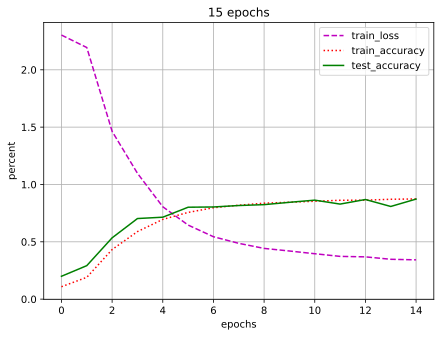

In [7]:
lr, num_epochs = 0.1, 15
start = time.perf_counter()
train_gpu(net, train_iter, test_iter, num_epochs, lr)
end = time.perf_counter()
print(f"Total Time : {end-start:3f}")

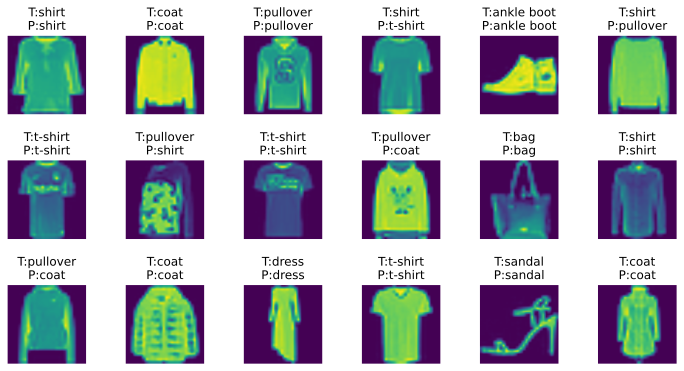

In [8]:
""" 获得标签索引对应文本"""
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', \
                 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

""" 打印图片 """
def show_img(imgs, num_rows, num_cols, title=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    plt.rcParams["figure.figsize"] = figsize
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i+1)
        plt.title(title[i])
        plt.axis('off')
        if torch.is_tensor(imgs[i].numpy()):
            plt.imshow(imgs[i].numpy())
        else:
            plt.imshow(imgs[i])

def predtic_ch3(net, test_iter, rows, cols):
    n = rows * cols
    for X, y in test_iter:
        break
    X = X.to(try_gpu())
    trues = get_fashion_mnist_labels(y)
    predicts = get_fashion_mnist_labels(net(X).argmax(axis=1))
    title = [f"T:{true}\nP:{predict}" for true, predict in zip(trues, predicts)]
    X = X.to(torch.device('cpu'))
    show_img(X[0:n].reshape([n, 224, 224]), rows, cols, title=title[0:n], scale=2)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
predtic_ch3(net, test_iter, 3, 6)

In [9]:
torch.cuda.empty_cache()

# QA

- 宽的隐藏层更容易过拟合
- 全局池化层
    - 利于计算
    - 大大地降低模型复杂度
    - 提升泛化性（大量使用）
    - 缺点：**收敛变慢**
    - 大概要扫120轮，而纯全连接`AlexNet`大概30轮就可以
